# 미니 프로젝트 : 시계열 데이터에서 이상치를 찾아보자

## Step 1. 데이터 구하기

In [1]:
import requests
import os

url = "https://query1.finance.yahoo.com/v7/finance/download/NQ=F?period1=969235200&period2=1603152000&interval=1d&events=history&includeAdjustedClose=true"

response = requests.get(url)

csv_file = os.path.dirname(os.path.abspath('__file__')) + r'/data/nasdaq.csv'

# response의 컨텐츠를 csv로 저장합니다
with open(csv_file, 'w') as fp:
    fp.write(response.text)

In [2]:
import pandas as pd

df = pd.read_csv(csv_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994.0
1,2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029.0
2,2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832.0
3,2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719.0
4,2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926.0


In [3]:
# 날짜 데이터를 Datetime 형식으로 바꿔줍니다
df.loc[:, 'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

In [4]:
# 결측치를 제거해줍니다.
print("삭제 전 데이터의 길이", len(df))

df = df.dropna(axis=0).reset_index(drop=True)
df.isna().sum()

삭제 전 데이터의 길이 6166


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
print("삭제 후 데이터의 길이", len(df))

삭제 후 데이터의 길이 5094


## Step 2. 기본 통계분석으로 이상치 찾기

- 데이터의 분포 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time Series Decompose를 수행한 후 residual로 분석하기

**한단계 더 나아가기**

- 왜 이상치로 분류되었는지 해석해보기
- 탐색해낸 이상치는 극단치인디, 특이치인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

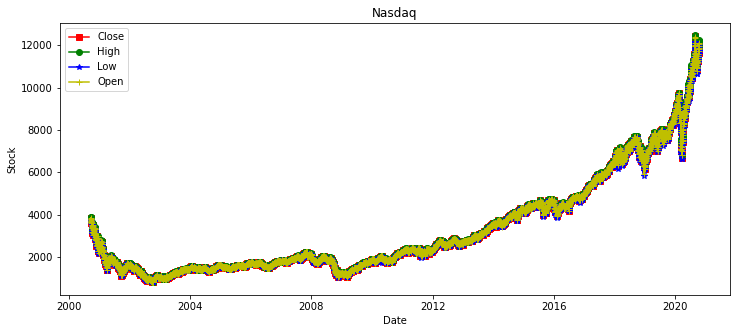

In [6]:
# 데이터 분포 그리기
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams['figure.figsize'] = (12, 5)

plt.plot(df.Date, df.Close, marker = 's', color = 'r')
plt.plot(df.Date, df.High, marker = 'o', color = 'g')
plt.plot(df.Date, df.Low, marker = '*', color = 'b')
plt.plot(df.Date, df.Open, marker = '+', color = 'y')

plt.title("Nasdaq")
plt.ylabel("Stock")
plt.xlabel("Date")
plt.legend(['Close', 'High', 'Low', 'Open'], loc = 'best')

plt.show()

In [7]:
df.loc[df.Low>df.High]

,Date,Open,High,Low,Close,Adj Close,Volume


2020년 3월 말에 갑자기 데이터가 급락한 것을 볼 수 있습니다. 다행히 Low > High인 값은 없어서 이상한 데이터는 없나봅니다.

#### z-test로 정규분포를 만족하는지 확인하기

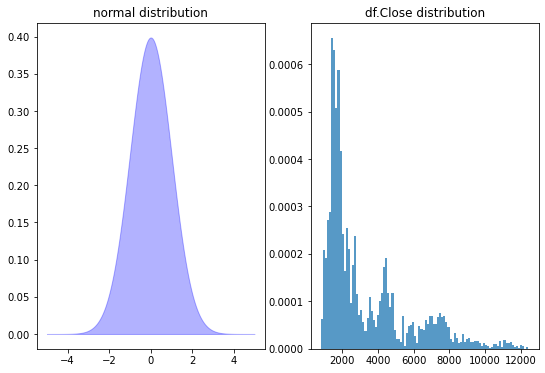

In [8]:
# 먼저 데이터의 분포 확인하기
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-5, 5, 0.001)
y = norm.pdf(x, 0, 1)
# 평균이 0이고 표준편차가 1인 정규분포를 그립니다

# build the plot
plt.figure(figsize = (9, 6))
plt.subplot(1, 2, 1)
plt.fill_between(x,y,0, alpha=0.3, color='b')
plt.title('normal distribution')

plt.subplot(1, 2, 2)
plt.hist(df.Close, 100, density = True, alpha = 0.75)
plt.title("df.Close distribution")
plt.show()

In [9]:
# z-test로 분포 확인하기
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


p가 0.0이 나왔습니다. 즉, 정규분포와 거리가 멀다고 할 수 있습니다. 이 데이터에 대해서 정규분포를 가정한 신뢰구간 분석을 적용해봅시다.

#### time series decomposition 수행 후 residual로 분석하기

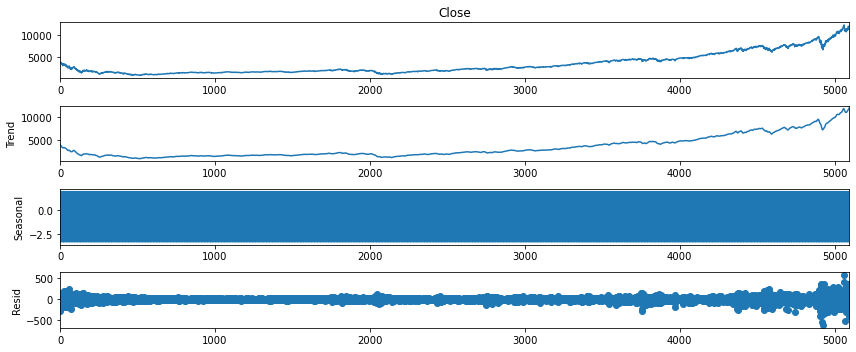

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.Close, model='additive', two_sided=True,
                           period = 10, extrapolate_trend = 'freq')
result.plot()
plt.show()

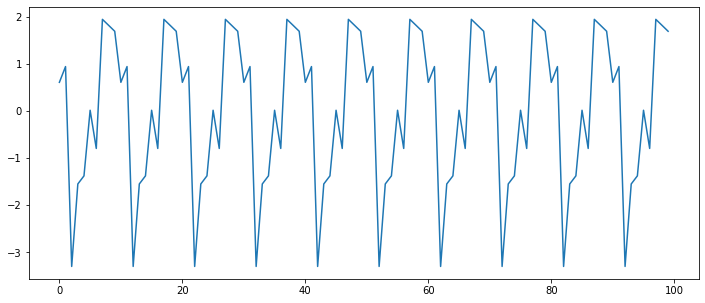

In [11]:
# seasonal 성분 다시 확인하기
result.seasonal[:100].plot()

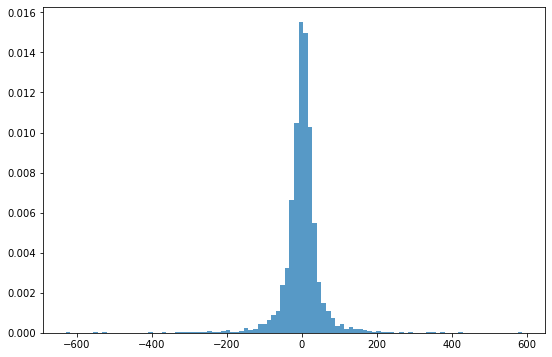

In [12]:
# residual의 분포를 그려봅시다
fig, ax = plt.subplots(figsize = (9, 6))
_ = plt.hist(result.resid, 100, density = True, alpha = 0.75)

정규분포에 가까워진 것 같습니다. z-test로 한번 확인해봅시다.

In [13]:
r = result.resid.values
st, p = ztest(r)
print(st, p)

-0.3016324194008281 0.7629322912826371


p가 0.05이상으로 아주 강하게 나타납니다. 정규분포로 가정하고 분석해봅시다.

## Step 3. Unsupervised Clustering 으로 이상치 찾기

- k-means로 분석하기
- DBSCAN으로 분석하기

**한 단계 더 나아가기**

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

In [14]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature마다 decompose를 수행
    for f in features:
        result = seasonal_decompose(df[f], model = 'additive', period=freq, extrapolate_trend = freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

tdf, sdf, rdf = my_decompose(df, features = ['Open', 'High', 'Low', 'Close', 'Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,3324.303285,3355.663089,3292.204015,3326.157530,287799.789978
std,2390.871506,2412.479986,2369.858940,2394.718369,109505.235488
min,914.415000,934.695000,895.770000,915.335000,64880.520000
25%,1584.251875,1597.572500,1571.058750,1584.191100,220550.460000
50%,2263.775000,2291.211250,2231.463750,2264.287900,268829.760000
75%,4433.603750,4464.010625,4399.788125,4434.981250,319616.697500
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [15]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5094.000000,5094.000000,5094.000000,5094.000000,5094.000000
mean,-1.494218,-1.447168,-1.394948,-1.402187,132.899742
std,113.106458,102.570229,117.278403,110.763008,110724.899203
min,-1280.163546,-1494.231533,-1226.595518,-1389.770659,-603014.586328
25%,-37.912202,-35.100432,-38.323649,-37.371552,-53397.033973
50%,3.575670,3.350366,4.153527,2.958782,-584.124075
75%,40.353926,37.613888,42.048756,40.813609,51481.304420
max,996.821566,933.584382,941.409836,996.232816,810690.898648


In [16]:
# 각 변수들 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)

print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.49421837  -1.44716848  -1.39494753  -1.40218679 132.89974227]


array([[ 0.94173218,  0.84218124,  0.81160865,  0.59799575,  0.083212  ],
       [ 0.48655464,  1.27770882,  1.3787828 ,  2.08212326,  0.10453018],
       [ 1.89305329,  2.00817542,  2.03390849,  2.72037058, -0.08887086],
       ...,
       [-0.65531897, -1.82608069, -0.96473553, -1.32833825,  0.28433475],
       [-1.31334711, -1.62375976, -0.70348768, -2.17905108, -0.36419423],
       [-2.12456827, -2.48917183, -2.57191425, -3.70655626, -0.28328824]])

#### k-means로 이상치 탐색하기

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
print(kmeans.labels_)

[ 1  1  3 ...  9  9 11]


In [18]:
lbl, cnt = np.unique(kmeans.labels_, return_counts = True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:1038',
 'group:1-count:454',
 'group:2-count:32',
 'group:3-count:106',
 'group:4-count:13',
 'group:5-count:20',
 'group:6-count:74',
 'group:7-count:204',
 'group:8-count:826',
 'group:9-count:442',
 'group:10-count:34',
 'group:11-count:105',
 'group:12-count:337',
 'group:13-count:414',
 'group:14-count:995']

4, 5번 그룹이 너무 작은 숫자가 나왔습니다. 한번 확인해보도록 합시다.

In [20]:
# 꼭 여러분들의 분류 결과에서 특이 그룹으로 분류된 그룹 번호로 바꿔 주세요. 
df[(kmeans.labels_==4)|(kmeans.labels_==5)]

,Date,Open,High,Low,Close,Adj Close,Volume
4891,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4892,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4893,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4894,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4895,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4896,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4897,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0
4898,2020-02-20,9744.750000,9763.000000,9517.000000,9624.250000,9624.250000,802424.0
4899,2020-02-21,9617.250000,9623.750000,9411.500000,9458.000000,9458.000000,911839.0
4900,2020-02-23,9355.250000,9365.000000,9289.000000,9315.000000,9315.000000,995989.0


코로롱 때문인가봐요. 2020년, 바로 올해네요

#### DBSCAN으로 이상치 찾기

In [21]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps = 0.7, min_samples = 2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [23]:
print(clustering.labels_)

[ 0  0  0 ...  0 -1 -1]


In [24]:
lbl, cnt = np.unique(clustering.labels_, return_counts = True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:196',
 'group:0-count:4839',
 'group:1-count:3',
 'group:2-count:12',
 'group:3-count:2',
 'group:4-count:2',
 'group:5-count:2',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:2',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:3',
 'group:22-count:2',
 'group:23-count:2']

DBSCAN은 -부터 23까지 분류했네요!

## Step 4. LSTM 오토인코더로 이상치 찾기

- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

**한 단계 더 나아가기**

- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

#### 딥러닝을 위한 데이터셋 찾기

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
# 모델 재현성을 위해 난수 시드 설정을 해줍니다.
tf.random.set_seed(777)
np.random.seed(777)

#### LSTM을 이요해 오토인코더 모델 생성하기

데이터 전처리
- 입력 변수를 정규화
- 가장 일반적인 표준 정규분포로 전처리!

In [27]:
from sklearn.preprocessing import StandardScaler

window_size = 10
batch_size = 32
features = ['Open', 'High', 'Low', 'Close', 'Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE, features].values)
scaled = scaler.transform(df[features].values)

keras의 `TimeseriesGenerator`를 이용해 데이터셋 만들기

In [29]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride = 1,
    sampling_rate =1,
    batch_size = batch_size,
    shuffle = False,
    start_index = 0,
    end_index = None
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride = 1,
    sampling_rate = 1,
    batch_size = batch_size,
    shuffle = False,
    start_index = TRAIN_SIZE,
    end_index = None
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


**모델 만들기**

- 2개 층의 LSTM
- ReapeatVector는 Input을 window size만큼 복사시킴

In [30]:
model = Sequential([
    # 인코더 시작
    LSTM(64, activation = 'relu', return_sequences=True,
        input_shape = (window_size, n_features)),
    LSTM(16, activation = 'relu', return_sequences=False),
    # 인코더 끝
    # BottleNeck 시작
    RepeatVector(window_size),
    # BottleNeck 끝
    # 디코더 시작
    LSTM(16, activation = 'relu', return_sequences = True),
    LSTM(64, activation = 'relu', return_sequences = False),
    Dense(n_features)
    # 디코더 끝
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [31]:
## 체크포인트. 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠.
import os

checkpoint_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/checkpoint/mymodel.ckpt'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only = True,
    save_best_only = True,
    monitor = 'val_loss',
    verbose = 1
)

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience = 5)

In [33]:
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['mae'])

In [ ]:
hist = model.fit(
    train_gen,
    validation_data = valid_gen,
    steps_per_epoch = len(train_gen),
    validation_steps = len(valid_gen),
    epochs = 10,
    callbacks = [checkpoint, early_stop]
)